In [38]:
import torch 
import torch.nn as nn
import requests
import zipfile
from pathlib import Path
import os 
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset

In [39]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Setup the Dataset


In [40]:
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True,exist_ok=True)
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip",'w') as zf:
        request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip")

data\pizza_steak_sushi already exists


### Data exploration 


In [41]:
def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directors and {len(filenames)} files in {dirpath}")

walk_through_dir(image_path)

there are 2 directors and 0 files in data\pizza_steak_sushi
there are 3 directors and 0 files in data\pizza_steak_sushi\test
there are 0 directors and 25 files in data\pizza_steak_sushi\test\pizza
there are 0 directors and 19 files in data\pizza_steak_sushi\test\steak
there are 0 directors and 31 files in data\pizza_steak_sushi\test\sushi
there are 3 directors and 0 files in data\pizza_steak_sushi\train
there are 0 directors and 78 files in data\pizza_steak_sushi\train\pizza
there are 0 directors and 75 files in data\pizza_steak_sushi\train\steak
there are 0 directors and 72 files in data\pizza_steak_sushi\train\sushi


### Setup training and test path 


In [42]:
train_dir= image_path /"train"
test_dir= image_path /"test"    
print(f"there are {len(os.listdir(train_dir))} classes in the training directory")
print(f"there are {len(os.listdir(test_dir))} classes in the test directory")

there are 3 classes in the training directory
there are 3 classes in the test directory


### Visualize the data 

random image path:data\pizza_steak_sushi\test\sushi\2394442.jpg and class is :sushi


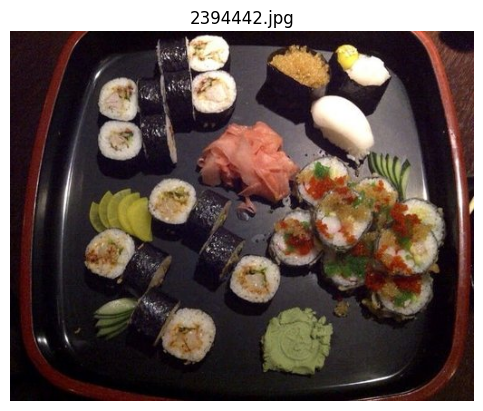

 random image path : data\pizza_steak_sushi\test\sushi\2394442.jpg and class is : sushi


In [43]:
random .seed(42)
#get a random image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
#print(image_path_list)
random_image_path=random.choice(image_path_list)
image_class=random_image_path.parent.stem
print(f"random image path:{random_image_path} and class is :{image_class}")
#open the image and plot it
img=Image.open(random_image_path)   
#print(img)
plt.imshow(img)
plt.axis(False)
plt.title(random_image_path.name)
plt.show()
print (f" random image path : {random_image_path} and class is : {image_class}")


(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

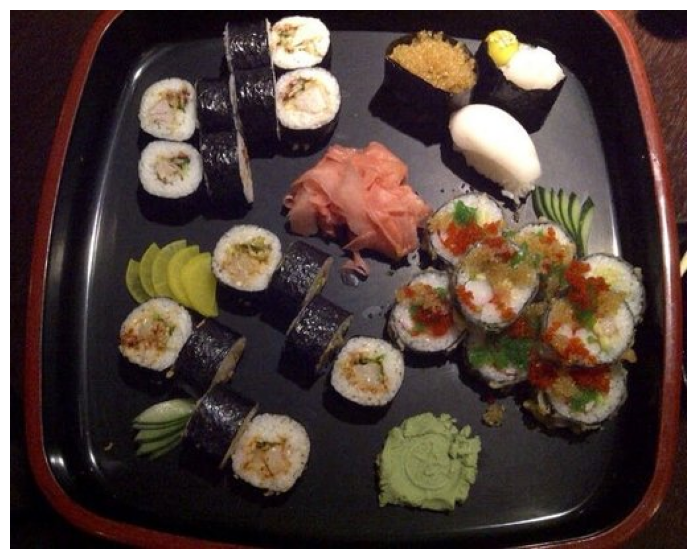

In [44]:
img_as_array=np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)

#print(f"image as array : {img_as_array} and shape is : {img_as_array.shape}")

### TuRn ALl IMAGES InTo Tensors

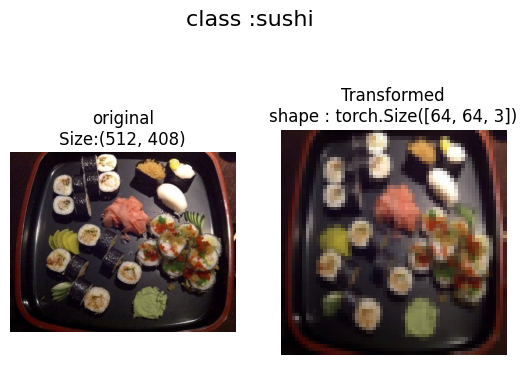

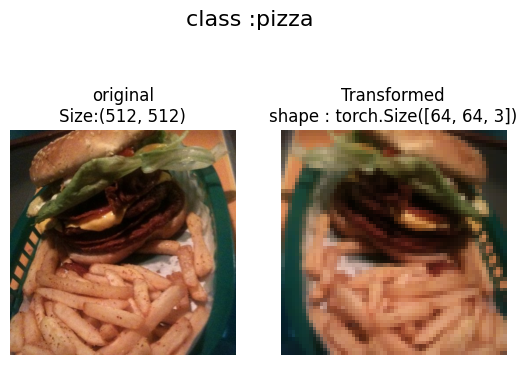

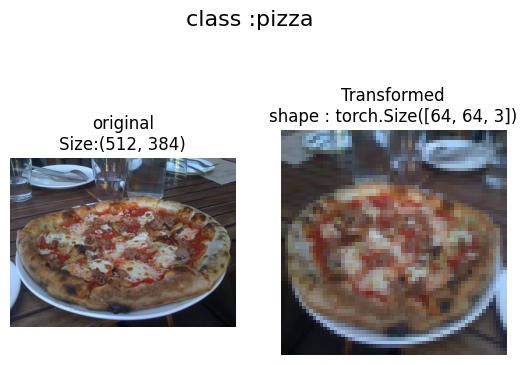

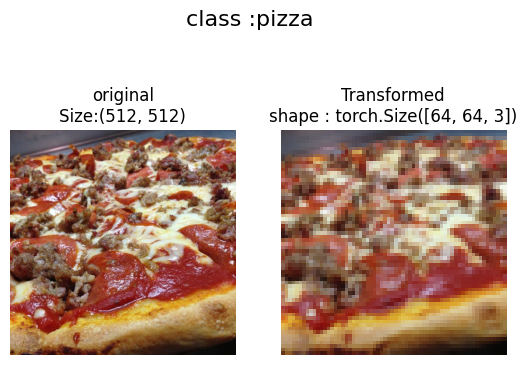

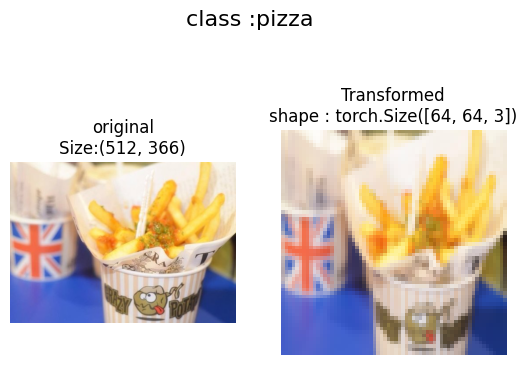

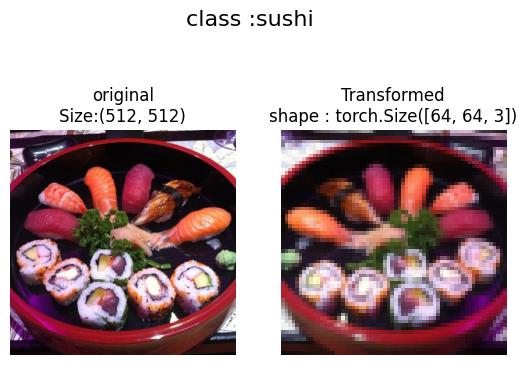

In [45]:
data_transform=transforms.Compose([# Resize the image 
                                    transforms.Resize(size=(64,64)),
                                    #flip the image randomly on the horizontal axis
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    #convert the image to a tensor
                                    transforms.ToTensor()
                                    ])
def plot_transformed_images (image_paths:list,transform,n=3,seed=None):
    if seed :
        random.seed(seed)
    random_image_paths= random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax =plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"original\nSize:{f.size}")
            ax[0].axis("off")
    # Transform the image
            transformed_image=transform(f).permute(1, 2, 0)
            #ax[1].imshow(transformed_image)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nshape : {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"class :{image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path_list,data_transform,n=6,seed=42)

### / Loading image Folder

In [46]:

# 4
test_data=datasets.ImageFolder(root=test_dir,
                                transform=data_transform,target_transform=None)
train_data =datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,target_transform=None)

In [47]:
# 4
test_data=datasets.ImageFolder(root=test_dir,
                                transform=data_transform,target_transform=None)

In [48]:
class_names=train_data.classes
class_dict=train_data.class_to_idx
print(f"class names :{class_names}")
 

class names :['pizza', 'steak', 'sushi']


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

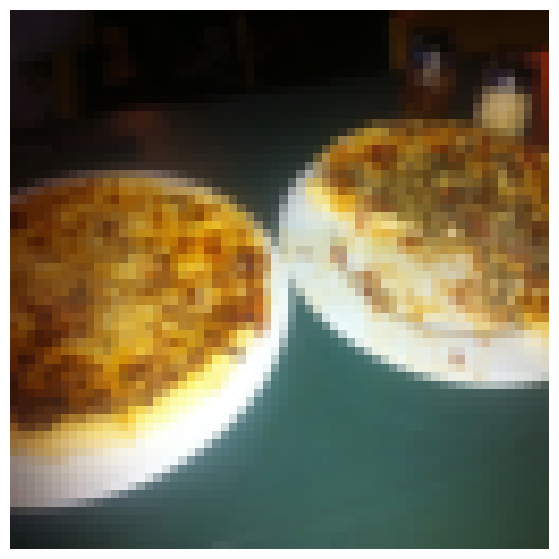

In [49]:
img,label= train_data[0][0],train_data[0][1] 
img_permute=img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)

In [50]:
# turn loaded images into dataloader

batch_size=1
train_dataloader=DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)
train_dataloader

In [51]:
img, label= next(iter(train_dataloader))



## Loading image data with a custom dataset

In [52]:
from typing import Tuple,List, Dict
## Loading image data with a custom dataset
# setup the target directory structure
target_directory=train_dir
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])



In [53]:
def find_classes(directory:str)-> Tuple[list[str],Dict[str,int]]:
    classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"couldn't find any classes in {directory}  ")
    class_to_idx={class_name:i for i ,class_name in enumerate(classes)}
    return classes,class_to_idx

In [54]:
#create a custom dataset to replicate torchvision.datasets.ImageFolder
from torch.utils.data import Dataset
from PIL import Image
import pathlib

class ImageFolderCustom(Dataset):
    def __init__(self,targ_dir:str,transform=None):
        self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        #setup transform
        self.transform=transform
        #class and class to index
        self.classes,self.class_to_idx=find_classes(targ_dir)
        #create a function to load the images 
    def load_image (self,index:int )->Image.Image:
            image_path=self.paths[index]
            return Image.open(image_path)
    def __len__ (self)-> int:
        return len (self.paths)
    def __getitem__(self, index:int)-> Tuple[torch.Tensor,int]:
        img=self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx= self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img),class_idx
        else:
            return img, class_idx
        

In [55]:
train_transforms= transforms.Compose([ transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5)
                                        ,transforms.ToTensor()]) 
test_transforms=transforms.Compose([transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()])
# Test out ImageFolderCustom 
train_data_custom= ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

In [56]:
import torch
import random
import matplotlib.pyplot as plt
from typing import List
# Create a function to take in dataset 
def display_random_image (dataset: torch.utils.data.Dataset,
                            classes:List[str]=None,
                            n : int =10,
                            display_shape:bool=True,
                                seed : int =None):
    if n >10 :
        n=10
        display_shape=False
        print( f"for display , purpose , n  shouldn't be larger than 10, setting to 10 and removing shape display")
    if seed :
        random.seed(seed)
    random_sample_idx= random.sample(range(len(dataset)),k= n)
    plt.figure(figsize=(16,8))
    for i, targ_sample in enumerate (random_sample_idx):
        targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]
        target_image_adjust=   targ_image.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if classes :
          title=f"class:{classes[targ_label]}"
          if display_shape:
                title=title+ f"\n{target_image_adjust.shape}"
        plt.title(title)

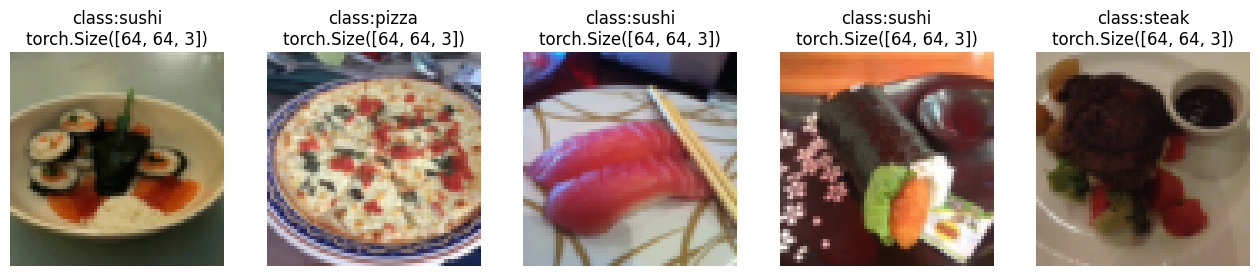

In [57]:
display_random_image(train_data, n=5, classes=class_names, seed=None)


In [58]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [62]:
batch_size=32
num_workers=0
train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=batch_size,
                                    num_workers=num_workers
                                    ,shuffle=True)
test_dataloader_custom=DataLoader(dataset=test_data_custom,
                                    batch_size=batch_size,
                                    num_workers=num_workers,
                                    shuffle=False)
img_custom,label_custom=next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
from torchvision import transforms 
train_transform=transforms.Compose([transforms.Resize(size=(244,244)),
                                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                        transforms.ToTensor() ] )




In [65]:
image_path_list=list(image_path.glob("*/*/*.jpg"))

In [63]:
from torch.utils.data import DataLoader

dl = DataLoader(train_data_custom, batch_size=32, shuffle=True, num_workers=0)
batch = next(iter(dl))
print("ok", batch[0].shape, batch[1].shape)


ok torch.Size([32, 3, 64, 64]) torch.Size([32])
